In [ ]:
## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
## Load Dataset

In [2]:
house_df = pd.read_csv('C:/Users/ASWIN/Documents/python/projects/train.csv')
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
## Missing Value Handling Functions

In [5]:
def separate_cols(df):
    numeric_cols = []
    categorical_cols = []

    for col in df.columns:
        missing = df[col].isna().sum()
        if missing > 0:
            if df[col].dtype in ["int64", "float64"]:
                numeric_cols.append(col)
            else:
                categorical_cols.append(col)
    return numeric_cols, categorical_cols
separate_cols(house_df)


(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'],
 ['Alley',
  'MasVnrType',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature'])

In [ ]:
## Clean Missing Values

In [6]:
# MasVnrArea
house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)

# GarageYrBlt
house_df.loc[house_df['GarageType'].isna(), 'GarageYrBlt'] = 0
house_df.loc[(house_df['GarageType'].notna()) & (house_df['GarageYrBlt'].isna()),'GarageYrBlt'] = house_df['YearBuilt']

# LotFrontage by Neighborhood
grp = house_df.groupby(['Neighborhood'])['LotFrontage'].median()
for ind,val in zip(grp.index,grp.values):
    house_df.loc[(house_df['Neighborhood'] == ind) & (house_df['LotFrontage'].isna()),['LotFrontage']] = val

# Electrical
house_df['Electrical'] = house_df['Electrical'].fillna(house_df['Electrical'].mode()[0])

# Fill "no feature" columns
fill_none_cols = ['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature']
house_df[fill_none_cols] = house_df[fill_none_cols].fillna('None')

# Garage Types
garage_cols = ['GarageType','GarageFinish','GarageQual','GarageCond']
house_df.loc[house_df['GarageType'].isna(), garage_cols] = 'None'

# Basement Types
bsmt_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
house_df.loc[house_df['BsmtQual'].isna(), bsmt_cols] = 'None'
house_df['BsmtExposure'] = house_df['BsmtExposure'].fillna(house_df['BsmtExposure'].mode()[0])
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].fillna(house_df['BsmtFinType2'].mode()[0])


In [7]:
# Outliers & Fix Incorrect Values

In [19]:
def check_for_outliers(df):
    for col in df.columns:
        if df[col].dtype in ["int64", "float64"]:
            print(f'{col}: min={df[col].min()}, max={df[col].max()}')

check_for_outliers(house_df)

# Fix incorrect kitchen value
house_df.loc[954,'KitchenAbvGr'] = 1


Id: min=1, max=1460
MSSubClass: min=20, max=190
LotFrontage: min=21.0, max=313.0
LotArea: min=1300, max=215245
OverallQual: min=1, max=10
OverallCond: min=1, max=9
YearBuilt: min=1872, max=2010
YearRemodAdd: min=1950, max=2010
MasVnrArea: min=0.0, max=1600.0
BsmtFinSF1: min=0, max=5644
BsmtFinSF2: min=0, max=1474
BsmtUnfSF: min=0, max=2336
TotalBsmtSF: min=0, max=6110
1stFlrSF: min=334, max=4692
2ndFlrSF: min=0, max=2065
LowQualFinSF: min=0, max=572
GrLivArea: min=334, max=5642
BsmtFullBath: min=0, max=3
BsmtHalfBath: min=0, max=2
FullBath: min=0, max=3
HalfBath: min=0, max=2
BedroomAbvGr: min=0, max=8
KitchenAbvGr: min=1, max=3
TotRmsAbvGrd: min=2, max=14
Fireplaces: min=0, max=3
GarageYrBlt: min=0.0, max=2010.0
GarageCars: min=0, max=4
GarageArea: min=0, max=1418
WoodDeckSF: min=0, max=857
OpenPorchSF: min=0, max=547
EnclosedPorch: min=0, max=552
3SsnPorch: min=0, max=508
ScreenPorch: min=0, max=480
PoolArea: min=0, max=738
MiscVal: min=0, max=15500
MoSold: min=1, max=12
YrSold: min=

In [ ]:
Feature Engineering

In [9]:
# Age of house
house_df['Age'] = 2025 - house_df['YearBuilt']

# Total square foot
house_df['TotalSquareFoot'] = house_df['TotalBsmtSF'] + house_df['1stFlrSF'] + house_df['2ndFlrSF']

# Time since remodel
house_df['SinceRemodel'] = house_df['YrSold'] - house_df['YearRemodAdd']

# Total bathrooms
house_df['TotalBathrooms'] = (
    house_df['FullBath'] + house_df['HalfBath']*0.5 +
    house_df['BsmtFullBath'] + house_df['BsmtHalfBath'] * 0.5
)

# Porch area
house_df['TotalPorchSF'] = (
    house_df['OpenPorchSF'] + house_df['EnclosedPorch'] +
    house_df['3SsnPorch'] + house_df['ScreenPorch']
)

# Total rooms
house_df['TotalRooms'] = house_df['TotRmsAbvGrd'] + house_df['BedroomAbvGr']

# Age at sale
house_df['HouseAgeAtSale'] = house_df['YrSold'] - house_df['YearBuilt']


In [ ]:
## Ordinal Encoding

In [10]:
df = house_df.copy()

qual_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
bsmt_exposure_map = {'None':0,'No':1,'Mn':2,'Av':3,'Gd':4}
bsmt_fin_map = {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
functional_map = {'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
land_slope_map = {'Gtl':1,'Mod':2,'Sev':3}
paved_drive_map = {'N':0,'P':1,'Y':2}
central_air_map = {'N':0,'Y':1}
utilities_map = {'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub':4}

ordinal_cols = {
    'ExterQual': qual_map, 'ExterCond': qual_map, 'BsmtQual': qual_map,
    'BsmtCond': qual_map, 'KitchenQual': qual_map, 'HeatingQC': qual_map,
    'FireplaceQu': qual_map, 'GarageQual': qual_map, 'GarageCond': qual_map,
    'PoolQC': qual_map, 'BsmtExposure': bsmt_exposure_map,
    'BsmtFinType1': bsmt_fin_map, 'BsmtFinType2': bsmt_fin_map,
    'Functional': functional_map, 'LandSlope': land_slope_map,
    'PavedDrive': paved_drive_map, 'CentralAir': central_air_map,
    'Utilities': utilities_map
}

for col, mapping in ordinal_cols.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)


In [ ]:
## One-Hot Encoding

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
## Split Data

In [12]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
## Model Definitions

In [20]:
models = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),

    'RidgeCV': Pipeline([
        ('scaler', StandardScaler()), 
        ('ridge', RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5))
    ]),

    'LassoCV': Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, max_iter=5000))
    ]),

    'ElasticNetCV': Pipeline([
        ('scaler', StandardScaler()),
        ('en', ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9], alphas=np.logspace(-4,1,50), cv=5, max_iter=5000))
    ])
}


In [ ]:
## Train & Evaluate Model

In [16]:
results = []

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    step = list(pipeline.named_steps.values())[-1]
    chosen_alpha = getattr(step, 'alpha_', None)
    chosen_l1_ratio = getattr(step, 'l1_ratio_', None)

    results.append({
        'model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'alpha': chosen_alpha,
        'l1_ratio': chosen_l1_ratio
    })

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
results_df


,model,MAE,RMSE,R2,alpha,l1_ratio
0,RidgeCV,19369.681269,33111.657099,0.857062,562.341325,NaN
1,ElasticNetCV,19520.333666,34004.579092,0.849249,2.442053,0.7
2,LassoCV,21912.206750,50481.861527,0.667756,10.000000,NaN
3,LinearRegression,22154.888745,50655.500965,0.665467,NaN,NaN


In [21]:
## Finalize Best Model (RidgeCV)

In [22]:
final_model = models['RidgeCV']
final_model.fit(X_train, y_train)
ridge_preds = final_model.predict(X_test)

In [23]:
## Residual Plot

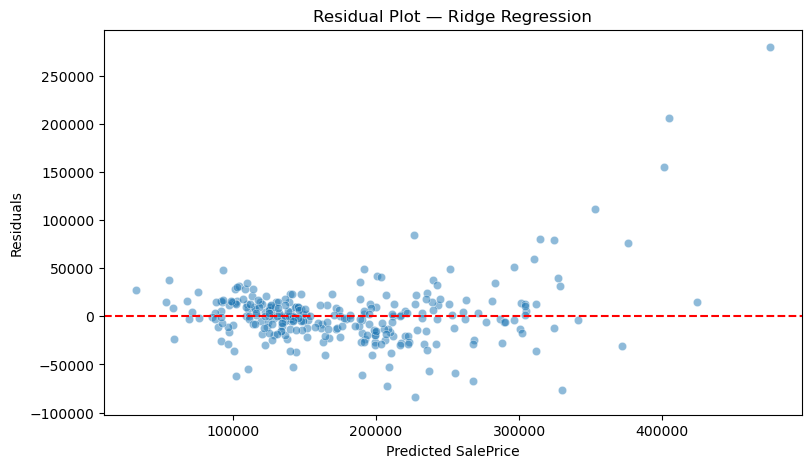

In [24]:
residuals = y_test - ridge_preds

plt.figure(figsize=(9,5))
sns.scatterplot(x=ridge_preds, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot — Ridge Regression")
plt.show()


In [25]:
## Predicted vs Actual

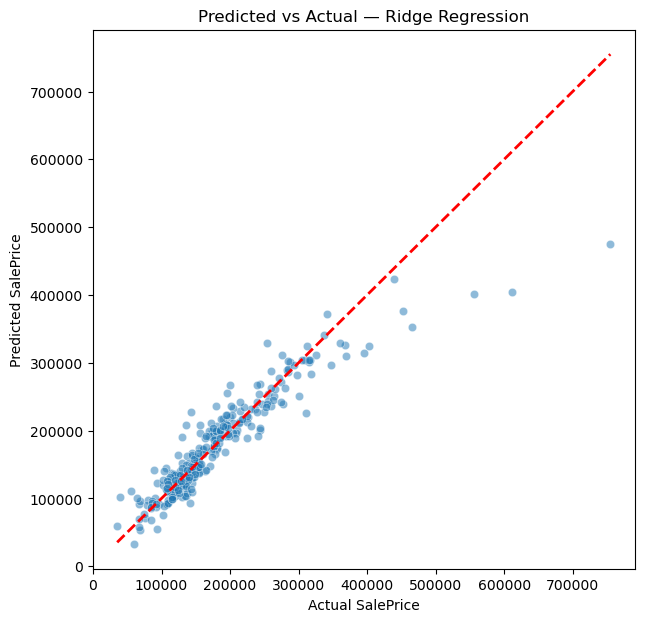

In [26]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=ridge_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual — Ridge Regression")
plt.show()

In [ ]:
## Feature Importance

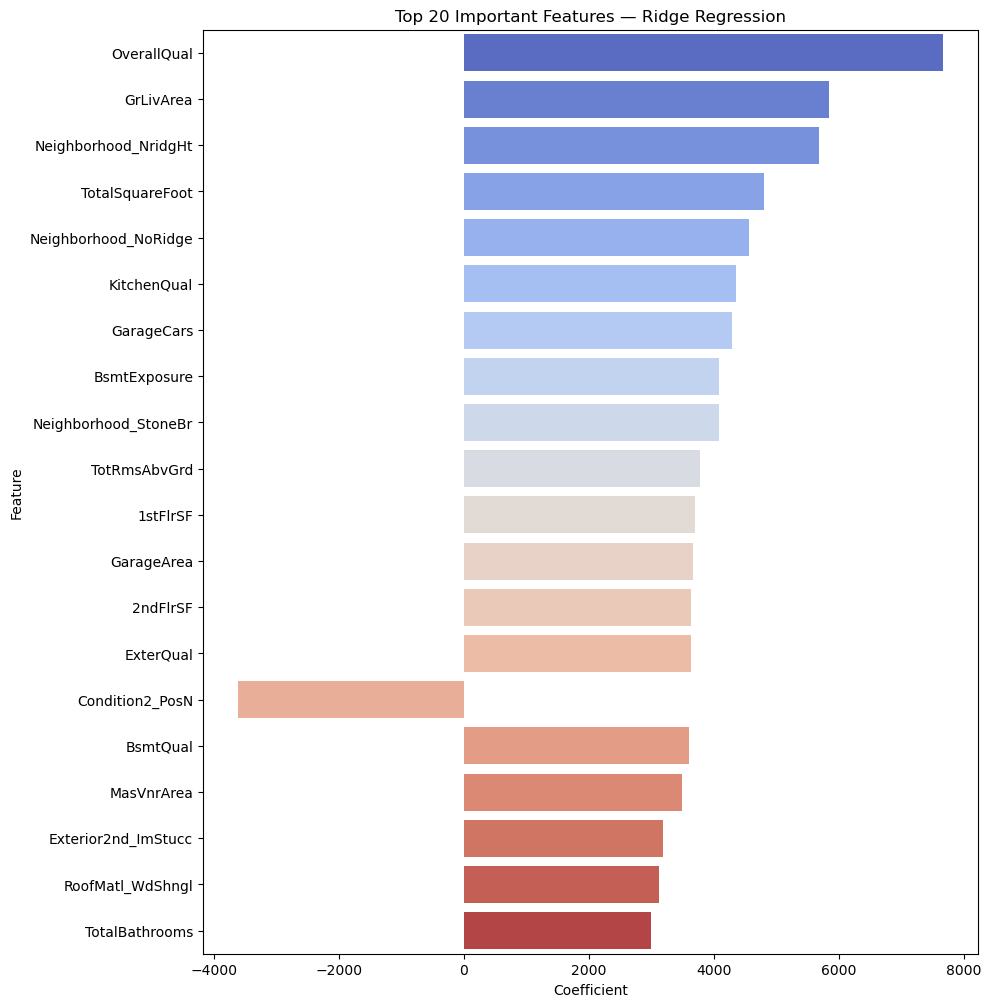

In [30]:
ridge_step = final_model.named_steps['ridge']
coef = ridge_step.coef_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef
})

importance_df = importance_df.reindex(importance_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10,12))
sns.barplot(data=importance_df.head(20), x='Coefficient', y='Feature', hue='Feature', legend=False, palette='coolwarm')
plt.title("Top 20 Important Features — Ridge Regression")
plt.show()


In [28]:
## Summary

In [29]:
print("🏁 FINAL SUMMARY (Ridge Regression)")
print("------------------------------------")
print("MAE:", mean_absolute_error(y_test, ridge_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, ridge_preds)))
print("R²:", r2_score(y_test, ridge_preds))

print("\n✔ RidgeCV selected as final model.")
print("✔ Best performance among all tested models.")
print("✔ Residuals look randomly distributed.")
print("✔ Predictions align strongly with actual values.")
print("✔ Ready for deployment!")


🏁 FINAL SUMMARY (Ridge Regression)
------------------------------------
MAE: 19369.681269110424
RMSE: 33111.657098602474
R²: 0.8570619024275503

✔ RidgeCV selected as final model.
✔ Best performance among all tested models.
✔ Residuals look randomly distributed.
✔ Predictions align strongly with actual values.
✔ Ready for deployment!
